In [1]:
#! pip install neptune-client

In [2]:
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install torch-geometric

In [3]:
#!pip install tensorboardX

In [33]:
import time
import random
import sys
import numpy as np
import torch
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from statistics import mean, pstdev
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score,roc_curve,auc,classification_report,confusion_matrix,ConfusionMatrixDisplay

from tensorflow.keras.utils import to_categorical


In [5]:
#for Data Loader

import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.io import read_tu_data
from torch_geometric.io import read_txt_array
import os.path as osp


In [6]:
#for Model

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



In [7]:
parser = argparse.ArgumentParser()
#parser.add_argument('cuda', action='store_true', default=False,
                   # help='Use CUDA for training.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200,help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01,help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,help='Weight decay for optimizer.')
parser.add_argument('--hidden', type=int, default=16,help='Number of hidden units.')
parser.add_argument('--dropout', type=float, default=0.5,help='Dropout rate (1 - keep probability).')
parser.add_argument('--train_split', type=float, default=0.8,help='Ratio of train split from entire dataset.Rest goes to test set')
parser.add_argument('--batch_size', type=int, default=16,help='batch size for loading mini batches of data')
parser.add_argument('--dataset_name', type=str, default='Train',help='Dataset name')


_StoreAction(option_strings=['--dataset_name'], dest='dataset_name', nargs=None, const=None, default='Train', type=<class 'str'>, choices=None, help='Dataset name', metavar=None)

In [8]:
#For Test Data

parser1 = argparse.ArgumentParser()
#parser.add_argument('cuda', action='store_true', default=False,
                   # help='Use CUDA for training.')
parser1.add_argument('--seed', type=int, default=42, help='Random seed.')
parser1.add_argument('--epochs', type=int, default=200,help='Number of epochs to train.')
parser1.add_argument('--lr', type=float, default=0.01,help='Initial learning rate.')
parser1.add_argument('--weight_decay', type=float, default=5e-4,help='Weight decay for optimizer.')
parser1.add_argument('--hidden', type=int, default=16,help='Number of hidden units.')
parser1.add_argument('--dropout', type=float, default=0.5,help='Dropout rate (1 - keep probability).')
parser1.add_argument('--train_split', type=float, default=0.8,help='Ratio of train split from entire dataset.Rest goes to test set')
parser1.add_argument('--batch_size', type=int, default=16,help='batch size for loading mini batches of data')
parser1.add_argument('--dataset_name', type=str, default='Train_Test',help='Dataset name')


_StoreAction(option_strings=['--dataset_name'], dest='dataset_name', nargs=None, const=None, default='Train_Test', type=<class 'str'>, choices=None, help='Dataset name', metavar=None)

In [9]:
import sys
sys.argv=['']
del sys

In [10]:
args = parser.parse_args()
args1 = parser1.parse_args()

In [11]:
# Training settings

'''args = parser.parse_args()
if args.cuda:
	if torch.cuda.is_available():
		device = torch.device('cuda')
		torch.cuda.manual_seed(args.seed)
	else:
		print("Sorry no gpu found!!")
		device=torch.device('cpu')
		print("Running model on cpu")
else:
	device=torch.device('cpu')
	'''


'args = parser.parse_args()\nif args.cuda:\n\tif torch.cuda.is_available():\n\t\tdevice = torch.device(\'cuda\')\n\t\ttorch.cuda.manual_seed(args.seed)\n\telse:\n\t\tprint("Sorry no gpu found!!")\n\t\tdevice=torch.device(\'cpu\')\n\t\tprint("Running model on cpu")\nelse:\n\tdevice=torch.device(\'cpu\')\n\t'

In [12]:
#DATALOADER


class GraphDataset(InMemoryDataset):
    def __init__(self, root, name, transform=None, pre_transform=None,
                 pre_filter=None, use_node_attr=False, use_edge_attr=False):
        self.name = name
        super(GraphDataset, self).__init__(root, transform, pre_transform,
                                        pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        self.data.y = self.data.y
        if self.data.x is not None and not use_node_attr:
            num_node_attributes = self.num_node_attributes
            self.data.x = self.data.x[:, num_node_attributes:]
        if self.data.edge_attr is not None and not use_edge_attr:
            num_edge_attributes = self.num_edge_attributes
            self.data.edge_attr = self.data.edge_attr[:, num_edge_attributes:]

    @property
    def raw_dir(self):
        name = 'raw{}'.format('')
        return osp.join(self.root, self.name, name)

    @property
    def processed_dir(self):
        name = 'processed{}'.format('')
        return osp.join(self.root, self.name, name)

    @property
    def num_node_labels(self):
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self):
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self):
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self):
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    @property
    def raw_file_names(self):
        names = ['A', 'graph_indicator','graph_labels','node_attributes','node_labels']
        return ['{}_{}.txt'.format(self.name, name) for name in names]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        #torch_geometric.io.parse_txt_array = parse_txt_array
        self.data, self.slices = read_tu_data(self.raw_dir, self.name)

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [self.pre_transform(data) for data in data_list]
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.name, len(self))

    

In [13]:
#MODEL

class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.5), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.5
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1),F.softmax(x,dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [14]:
#Setting seed to reproduce results
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

print(args.dataset_name)
dataset = GraphDataset(root=r'C:\Users\hvard\Desktop\Project', name=args.dataset_name, use_node_attr=True)
data_size = len(dataset)

Train


In [15]:
#Setting seed to reproduce results
random.seed(args1.seed)
np.random.seed(args1.seed)
torch.manual_seed(args1.seed)

print(args1.dataset_name)
test_dataset = GraphDataset(root=r'C:\Users\hvard\Desktop\Project', name=args1.dataset_name, use_node_attr=True)
test_data_size = len(test_dataset)

Train_Test


In [16]:
test_dataset[0].x

tensor([[-0.4333,  1.0000,  0.0000],
        [ 0.8049,  1.0000,  0.0000],
        [ 0.8049,  1.0000,  0.0000],
        ...,
        [ 0.8049,  1.0000,  0.0000],
        [ 0.8049,  1.0000,  0.0000],
        [ 0.8049,  1.0000,  0.0000]])

In [17]:
for i in range(len(test_dataset)):
    print((test_dataset[i].y))

tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tens

In [18]:
#checking some of the data attributes comment out these lines if not needed to check
print("*"*10)
print(data_size)
print(dataset.num_node_labels)
print(args.hidden)
print(args.dropout)
print(dataset)
print("*"*10)

print("*"*10)
print(test_data_size)
print(test_dataset.num_node_features)
print(args1.hidden)
print(args1.dropout)
print(test_dataset)
print("*"*10)

n_classes=dataset.num_classes
class_list=[]
for i in range(0,n_classes):
    class_list.append(i)

print(n_classes)

**********
646
2
16
0.5
Train(646)
**********
**********
100
3
16
0.5
Train_Test(100)
**********
2


In [44]:
#printing confusion matrix
def show_confusion_matrix(validations, predictions):
  
    LABELS=[0,1]
    matrix = confusion_matrix(validations, predictions,labels=[0,1])
    print(matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=LABELS)
    disp.plot()


In [45]:
from torch_geometric.data import Data, DataLoader
import torch_geometric.nn as pyg_nn
#import Model as M

#applying k-fold cross validation
def crossvalid(dataset=None,k_fold=5):
    
    global precision,recall,f1
    
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction) 
    index=0
    test_accs=[]
    train_time=0
    test_time=0
    for i in range(k_fold):
        if(i==k_fold-1):
            print("Running for {} fold".format(index+1))
            index=index+1
            trll = 0
            trlr = i * seg
            vall = trlr
            valr = i * seg + seg
            trrl = valr
            trrr = total_size
            
            train_left_indices = list(range(trll,trlr))
            train_right_indices = list(range(trrl,trrr))
            
            train_indices = train_left_indices + train_right_indices
            val_indices = list(range(vall,valr))
            
            train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
            val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
            
            print(len(train_set),len(val_set))
            
            train_loader = DataLoader(train_set, batch_size=1,
                                              shuffle=True)
            val_loader = DataLoader(val_set, batch_size=1,
                                              shuffle=True)
                                              
            
            model = GNNStack(max(dataset[0].num_node_features, 1), 32, 2, task=task)
            opt = optim.Adam(model.parameters(), lr=0.001)
            
            loss_values=[]
            accuracy_values=[]
            
            train_start=time.time()  
            for epoch in range(1):
              total_loss = 0
              model.train()
              for batch in train_loader:
                
                opt.zero_grad()
                embedding, pred,soft= model(batch)
                label = batch.y
                if task == 'node':
                    pred = pred[batch.train_mask]
                    label = label[batch.train_mask]
                loss = model.loss(pred, label)
                loss.backward()
                opt.step()
                total_loss += loss.item() * batch.num_graphs
              total_loss /= len(train_loader.dataset)
              writer.add_scalar("loss", total_loss, epoch)
    
              if epoch % 1 == 0:
                train_acc = test(train_loader, model)
                print("Epoch {}. Train Loss: {:.4f}. Train accuracy: {:.4f}".format(
                    epoch, total_loss, train_acc))
                    
                loss_values.append(total_loss)
                accuracy_values.append(train_acc)
                
                writer.add_scalar("train accuracy", train_acc, epoch)
            
            train_end=time.time()
            print("Time taken for training: ",train_end-train_start)
            train_time+=(train_end-train_start)
            
            test_start=time.time()
            test_acc = test(val_loader, model, True)
            test_end=time.time()
            print("Test accuracy: {:.4f}".format(test_acc))
            print("Time taken for testing: ",test_end-test_start)
            test_time+=(test_end-test_start)
            
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(111)
            ax.set_title('Training loss and accuracy Vs Epoch')
            plt.plot(loss_values, color='red',label='Loss')
            plt.plot(accuracy_values, color='blue',label='Accuracy')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss and Accuracy')
            ax.legend(loc='best')
            plt.savefig(f"{k_fold}-fold_"+args.dataset_name+"_"+str(i+1)+".png")
            
            test_accs.append(test_acc)
                
    precision/=k_fold
    recall/=k_fold
    f1/=k_fold
    avg_test=sum(test_accs)/len(test_accs)
    train_time/=k_fold
    test_time/=k_fold
    print("------------")
    print("{} fold test accuracy {:.4f}, precision {:.4f}, recall {:.4f}, F1-score {:.4f}".format(k_fold,avg_test,precision,recall,f1))
    print("Average training time {:.3f}, average testing time {:.3f}".format(train_time,test_time))    




In [21]:
def train(dataset, task, writer):
    crossvalid(dataset)


In [22]:
global model

In [46]:
#function for calculating acc for different train-ratio
def eval_train_ratio(dataset, task, writer):
    
    global model
    train_ratios=[0.1,0.2,0.3]
    test_accuracies=[]
    train_accuracies=[]
    for tr in train_ratios:
        if task == 'graph':
            data_size = len(dataset)
            train_loader = DataLoader(dataset[:int(data_size * tr)], batch_size=1, shuffle=True)
            test_loader = DataLoader(dataset[int(data_size * tr):], batch_size=1, shuffle=True)
        else:
            test_loader = train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
        print("Train ratio: {:.1f}. No of training graphs: {}. No of testing graphs: {}".format(tr,len(train_loader),len(test_loader)))
        
        model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
        opt = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(10):
          total_loss = 0
          model.train()
          for batch in train_loader:
            
            opt.zero_grad()
            embedding, pred,_ = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
          total_loss /= len(train_loader.dataset)
          
        
        train_acc = test(train_loader, model)
        test_acc = test(test_loader, model, True)
        print("Test accuracy: {:.4f}".format(test_acc))
        test_accuracies.append(test_acc)
        train_accuracies.append(train_acc)
        
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.set_title('Training and testing accuracy Vs Train Ratio')
    plt.plot(train_ratios, train_accuracies, color='red', marker= 'o',label='Train Acc')
    plt.plot(train_ratios, test_accuracies, color='blue',marker= 'o', label='Test Acc')
    ax.set_xlabel('Train Ratio')
    ax.set_ylabel('Training and testing accuracy')
    ax.legend(loc='best')
    #plt.show()
    plt.savefig(f"iterative_training_"+args.dataset_name+".png")


In [47]:
def test(loader, model, is_test=False,is_validation=False):
    global precision,recall,f1
    global class_list,n_classes
    global cnt
    model.eval()
    
    correct = 0
    glabel=[]
    glabel1=[]
    gpred=[]
    gscore=[]
    for data in loader:
        with torch.no_grad():
            emb, pred,soft = model(data)
            var=soft.numpy()[0]
            pred = pred.argmax(dim=1)
            label = data.y
            
            
            if(is_test): 
                glabel.append(label.numpy()[0])
                glabel1.append(label.numpy())   
                gpred.append(pred.numpy()[0])
                gscore.append(var)
            

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    
    if(is_test):
        glabel=np.array(glabel)
        glabel1=np.array(glabel1)
        gpred=np.array(gpred)
        gscore=np.array(gscore)
        enlabel=to_categorical(glabel1,n_classes)
        
        
        
        p=precision_score(glabel, gpred, average="micro")
        r=recall_score(glabel, gpred, average="micro")
        f=f1_score(glabel, gpred, average="micro")
        
        print('F1: {}'.format(f))
        print('Precision: {}'.format(p))
        print('Recall: {}'.format(r))
        precision+=p
        recall+=r
        f1+=f
        
        print("\n...confusion matrix and classification report....\n")
        show_confusion_matrix(glabel,gpred)
        print(classification_report(glabel,gpred))

        print("\n")
        #generate roc curve
        tpr=dict()
        fpr=dict()
        roc_auc=dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _= roc_curve(enlabel[:, i], gscore[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        ax.set_title('ROC curve for all classes')
        colors=['red','blue','green','yellow','purple','orange']
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i],lw=2,label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))    
        ax.set_xlabel('False postive rate')
        ax.set_ylabel('True postive rate')
        ax.legend(loc='best')
        plt.savefig(f"roc_"+args.dataset_name+"_"+str(cnt)+".png")
        cnt+=1
        
    return correct / total


In [29]:
from tensorboardX import SummaryWriter
import time
from datetime import datetime

dataset = dataset.shuffle()
task = 'graph'
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))


In [30]:
#globals 
precision=0
recall=0
f1=0

cnt=1


Train ratio: 0.1. No of training graphs: 64. No of testing graphs: 582
F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[277   0]
 [  0 305]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       305

    accuracy                           1.00       582
   macro avg       1.00      1.00      1.00       582
weighted avg       1.00      1.00      1.00       582



Test accuracy: 1.0000
Train ratio: 0.2. No of training graphs: 129. No of testing graphs: 517


C:\Users\hvard\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[246   0]
 [  0 271]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       246
           1       1.00      1.00      1.00       271

    accuracy                           1.00       517
   macro avg       1.00      1.00      1.00       517
weighted avg       1.00      1.00      1.00       517



Test accuracy: 1.0000
Train ratio: 0.3. No of training graphs: 193. No of testing graphs: 453


C:\Users\hvard\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[217   0]
 [  0 236]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       1.00      1.00      1.00       236

    accuracy                           1.00       453
   macro avg       1.00      1.00      1.00       453
weighted avg       1.00      1.00      1.00       453



Test accuracy: 1.0000


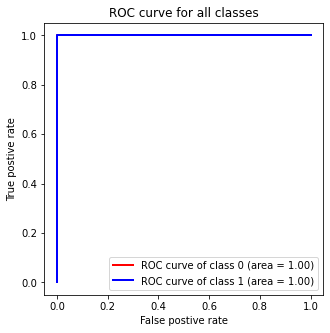

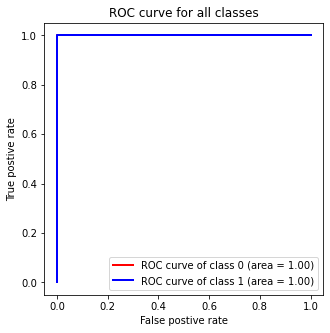

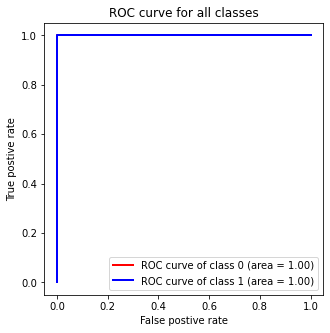

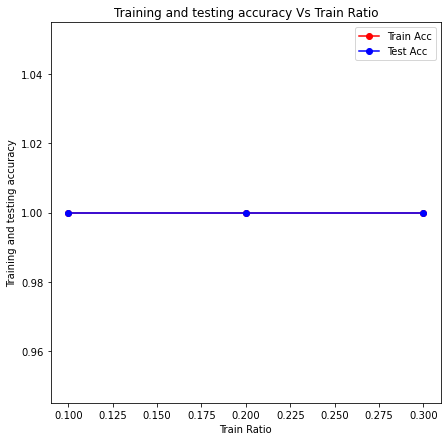

In [32]:
#train(X_train, task, writer)
eval_train_ratio(dataset, task, writer)


C:\Users\hvard\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[50  0]
 [ 0 50]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



Test accuracy: 1.0000


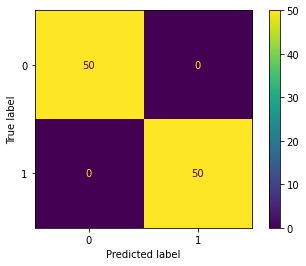

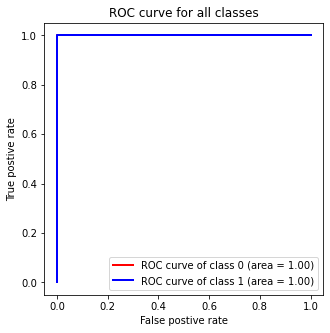

In [48]:
from torch_geometric.data import Data, DataLoader

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
test1 = test(test_loader, model, True)
print("Test accuracy: {:.4f}".format(test1))

In [209]:
c=0
d=0
for i in range(0,len(dataset)):
    if(dataset[i].y == 0 ) :
        c += 1
        print(dataset[i])
    if(dataset[i].y == 1):
        d+=1
print(c)
print(d)



# Gather some statistics about the first graph.
#print(f'Number of nodes: {dataset.num_nodes}')
#print(f'Number of edges: {dataset.num_edges}')
#print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
#print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
#print(f'Has self-loops: {dataset[0].has_self_loops()}')
#print(f'Is undirected: {dataset.is_undirected()}')

Data(edge_index=[2, 42546], x=[7336, 3], y=[1])
Data(edge_index=[2, 34054], x=[6434, 3], y=[1])
Data(edge_index=[2, 29936], x=[4848, 3], y=[1])
Data(edge_index=[2, 35228], x=[6330, 3], y=[1])
Data(edge_index=[2, 39886], x=[7017, 3], y=[1])
Data(edge_index=[2, 32464], x=[6596, 3], y=[1])
Data(edge_index=[2, 27778], x=[5096, 3], y=[1])
Data(edge_index=[2, 41372], x=[7679, 3], y=[1])
Data(edge_index=[2, 46320], x=[9068, 3], y=[1])
Data(edge_index=[2, 52892], x=[10680, 3], y=[1])
Data(edge_index=[2, 47862], x=[8176, 3], y=[1])
Data(edge_index=[2, 37960], x=[7263, 3], y=[1])
Data(edge_index=[2, 26686], x=[4864, 3], y=[1])
Data(edge_index=[2, 26170], x=[5395, 3], y=[1])
Data(edge_index=[2, 32240], x=[6032, 3], y=[1])
Data(edge_index=[2, 30124], x=[5592, 3], y=[1])
Data(edge_index=[2, 60850], x=[11474, 3], y=[1])
Data(edge_index=[2, 37684], x=[7439, 3], y=[1])
Data(edge_index=[2, 50044], x=[9002, 3], y=[1])
Data(edge_index=[2, 36748], x=[7277, 3], y=[1])
Data(edge_index=[2, 49766], x=[9222, 3

In [112]:
torch.save(model,'model.pt')

TypeError: cannot pickle 'module' object

In [ ]:
''' import cv2
import tensorflow as tf
import model as M

CATEGORIES = ["COVID","NON-COVID"]
def prepare(file):
    IMG_SIZE = 50
    img_array = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
model = M.GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
torch.save(model,'model.pt')


model = torch.load('model.pt')
image = "/content/drive/MyDrive/Github_edge/COVID/img-176.png" #your image path
prediction = model.predict([image])
prediction = list(prediction[0])
print(CATEGORIES[prediction.index(max(prediction))]



model = M.GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
opt = optim.Adam(model.parameters(), lr=0.001)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])




torch.save(model.state_dict(), 'mod.pt')


model = M.GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
model.load_state_dict(torch.load('mod.pt'))
model.eval()



from PIL import Image


image = Image.open("/content/drive/MyDrive/Github_edge/COVID/img-176.png") #your image path
print(image)

#image = image.view(max(dataset.num_node_features, 1), 32, dataset.num_classes)
output = model(image)
prediction = model.predict([image])
prediction = list(prediction[0])
print(CATEGORIES[prediction.index(max(prediction))])





#applying filter on a single image
def apply_filter(filename,filter):

  print("reading file---> "+str(filename))
  img=cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
  
  #img=cv2.resize(img,(250,250))  
  #comment out the above line if there is memory issue i.e. need to resize all images to smaller dim

  h, w = img.shape
  print("shape: "+str(h)+" x "+str(w)+"\n")
  # define filters
  horizontal = filter
  vertical = np.transpose(filter)

  # define images with 0s
  newhorizontalImage = np.zeros((h, w))
  newverticalImage = np.zeros((h, w))
  newgradientImage = np.zeros((h, w))

  # offset by 1
  for i in range(1, h - 1):
      for j in range(1, w - 1):
          horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                          (horizontal[0, 1] * img[i - 1, j]) + \
                          (horizontal[0, 2] * img[i - 1, j + 1]) + \
                          (horizontal[1, 0] * img[i, j - 1]) + \
                          (horizontal[1, 1] * img[i, j]) + \
                          (horizontal[1, 2] * img[i, j + 1]) + \
                          (horizontal[2, 0] * img[i + 1, j - 1]) + \
                          (horizontal[2, 1] * img[i + 1, j]) + \
                          (horizontal[2, 2] * img[i + 1, j + 1])

          newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

          verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                        (vertical[0, 1] * img[i - 1, j]) + \
                        (vertical[0, 2] * img[i - 1, j + 1]) + \
                        (vertical[1, 0] * img[i, j - 1]) + \
                        (vertical[1, 1] * img[i, j]) + \
                        (vertical[1, 2] * img[i, j + 1]) + \
                        (vertical[2, 0] * img[i + 1, j - 1]) + \
                        (vertical[2, 1] * img[i + 1, j]) + \
                        (vertical[2, 2] * img[i + 1, j + 1])

          newverticalImage[i - 1, j - 1] = abs(verticalGrad)

          # Edge Magnitude
          mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
          newgradientImage[i - 1, j - 1] = mag

  return newgradientImage





import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow



def convert_edge_image(image):
  print("\n\n---reading image "+image+"---\n")
  
	#applying Prewitt filter
  #for appyling any other filter change filter value accordingly i.e. the 2nd args for apply_filter()
  imagemat=apply_filter(image,np.array([[-1,0,1],[-1,0,1],[-1,0,1]]))
  cv2.imwrite(image,imagemat) #create the edge image and store it to consecutive filenames
  
  print("\n\n--saved image "+image+"--\n")



image = "/content/drive/MyDrive/Github_edge/COVID/img-176.png"
convert_edge_image(image)
img=cv2.imread(image,cv2.IMREAD_GRAYSCALE)
#print(cv2_imshow(img))






#define globals required through out the whole program
edges=[] #containing all edge tuple
attrs=[] #countaining list of attribute of all nodes
graph_id=1 #id of latest graph
node_id=1 #id of latest node
graph_indicator=[] #containing graph-id for each node
node_labels=[] #containing labels for all node
graph_labels=[]#containing labels for all graph


activity_map={}
activity_map[1]='COVID'
activity_map[2]='NON-COVID'




#z-score normalization
def normalize(arr):
  arr=np.array(arr)
  m=np.mean(arr)
  s=np.std(arr)
  return (arr-m)/s





#generate graph for a given edge-image file
def generate_graphs(image,node_label,activity_map):
  print(" ... Reading image: "+image+" ...")
  global node_id,edges,attrs,graph_id,node_labels,graph_indicator
  cnt=0
  img=cv2.imread(image)
  dim1,dim2,_=img.shape
  attrs1=[]

  print("\nPixel matrix is of: "+str(dim1)+"x"+str(dim2))
  img1=img.copy()
  nodes=np.full((dim1,dim2),-1)
  edge=0
  for i in range(dim1):
    for j in range(dim2):
      #considering pixel as node if pixel-value>=128
      b,_,_=img[i][j]
      if(b>=128):
        nodes[i][j]=node_id
        attrs1.append(b)
        graph_indicator.append(graph_id)
        node_labels.append([node_label,activity_map[node_label]])
        node_id+=1
        cnt+=1
      else:
        img1[i][j]=0
  
  for i in range(dim1):
    for j in range(dim2):
      #forming edge between all adjacent pixels which are node
      if(nodes[i][j]!=-1):
        li=max(0,i-1)
        ri=min(i+2,dim1)
        lj=max(0,j-1)
        rj=min(j+2,dim2)
        for i1 in range(li,ri):
          for j1 in range(lj,rj):
            if((i1!=i or j1!=j) and (nodes[i1][j1]!=-1)):
              edges.append([nodes[i][j],nodes[i1][j1]])
              edge+=1
  
  attrs1=normalize(attrs1)
  attrs.extend(attrs1)
  del attrs1
  print("For given image nodes formed: "+str(cnt)+" edges formed: "+str(edge))
  if(cnt!=0): 
    graph_id+=1





generate_graphs(image,1,activity_map)
graph_labels.append([1,activity_map[1]])






import pandas as pd


#create adjacency dataframe
df_A=pd.DataFrame(columns=["node-1","node-2"],data=np.array(edges))
print("Shape of edge dataframe: "+str(df_A.shape))
print("\n--summary of dataframe--\n" ,df_A.head())

#create node label dataframe
df_node_label=pd.DataFrame(data=np.array(node_labels),columns=["label","activity-name"])
print("shape of node-label dataframe: "+str(df_node_label.shape))
print("\n--summary of dataframe--\n" ,df_node_label.head())

#create graph label dataframe
df_graph_label=pd.DataFrame(data=np.array(graph_labels),columns=["label","activity-name"])
print("shape of node-label dataframe: "+str(df_graph_label.shape))
print("\n--summary of dataframe--\n" ,df_graph_label.head())

#create node-attribute dataframe (normalized grayscale value)
df_node_attr=pd.DataFrame(data=np.array(attrs),columns=["gray-val"])
print("shape of node-attribute dataframe: "+str(df_node_attr.shape))
print("\n--summary of dataframe--\n" ,df_node_attr.head())

#create graph-indicator datframe
df_graph_indicator=pd.DataFrame(data=np.array(graph_indicator),columns=["graph-id"])
print("shape of graph-indicator dataframe: "+str(df_graph_indicator.shape))
print("\n--summary of dataframe--\n" ,df_graph_indicator.head())

df_node_label=df_node_label.drop(["activity-name"],axis=1)
print(df_node_label.head())


df_graph_label=df_graph_label.drop(["activity-name"],axis=1)
print(df_graph_label.head())





def save_dataframe_to_txt(df,filepath):
  df.to_csv(filepath,header=None,index=None,sep=',',mode='w')







#save all the dataframes to .txt file
#path name: .../GraphTrain/dataset/<dataset_name>/raw/<dataset_name>_<type>.txt
# <type>:
# A--> adjancency matrix
#graph_indicator--> graph-ids of all node
#graph_labels--> labels for all graph
#node_attributes--> attribute(s) for all node
#node_labels--> labels for all node


sourcepath='/content/Github_Pretwitt/raw'
save_dataframe_to_txt(df_A,sourcepath+'/Github_Pretwitt_A.txt')
save_dataframe_to_txt(df_graph_indicator,sourcepath+'/Github_Pretwitt_graph_indicator.txt')
save_dataframe_to_txt(df_graph_label,sourcepath+'/Github_Pretwitt_graph_labels.txt')
save_dataframe_to_txt(df_node_attr,sourcepath+'/Github_Pretwitt_node_attributes.txt')
save_dataframe_to_txt(df_node_label,sourcepath+'/Github_Pretwitt_node_labels.txt')
 '''

SyntaxError: ignored